### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_size(8)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb
df_cdb.to_csv("./data/df_cdb.csv", index=False)

In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "E"

In [7]:
df_E = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "E"].copy()
df_E

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
5,2021-01-04,DEVRYNALDO RIZAL,JL JEND A YANI,KARANG JATI,BALIKPAPAN TENGAH,LAKI-LAKI,1978-12-18,Pegawai Swasta-Jasa,"> Rp. 6.000.000,-",SARJANA,ES5,E,INDIVIDU,46
7,2021-01-04,SUPARYANTO,JL KESATRIA PERUM NUSANTARA LESTARI,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1976-08-27,NaN,NaN,NaN,ES4,E,INSTANSI LUAR,48
14,2021-01-06,MULYADI,JL SYARIFUDIN YOES,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1974-12-23,Wiraswasta-Konstruksi,"> Rp. 6.000.000,-",SLTA/SMU,ES4,E,INDIVIDU,50
15,2021-01-06,MUHAMMAD FADILLAH,JL AL MAKMUR III,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1997-12-07,MAHASISWA/PELAJAR,"< Rp. 900.000,-",SLTP/SMP,ES4,E,INDIVIDU,27
18,2021-01-06,ANDI WIJAYANTO,JL SUGENG RAWUH II,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-07-06,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ES5,E,INDIVIDU,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6459,2024-06-30,PT KEMILAU INDAH NUSANTARA,JL. POROS SANGATTA-BENGALON KM. 32,MUARA BENGALON,BENGALON,LAKI-LAKI,1985-06-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,EG2,E,INDIVIDU,39
6523,2024-07-12,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGALON KM 32 SIMPANG RAWA ...,MUARA BENGALON,BENGALON,NaN,2000-11-18,Wiraswasta-Pertambangan,NaN,NaN,EG2,E,INSTANSI LUAR,24
6833,2024-08-29,PT KEMILAU INDAH NUSANTARA,JL POROS SANGATTA-BENGGALON KM 32 SIMPANG RAWA...,MUARA BENGALON,BENGALON,NaN,1992-08-27,NaN,NaN,NaN,EG2,E,INSTANSI LUAR,32
6841,2024-08-31,LINUS HARIMIN,JL BATU RATNA KM 11,KARANG JOANG,BALIKPAPAN UTARA,LAKI-LAKI,1973-09-23,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ESF,E,INDIVIDU,51


Plot data initial varian plus "E"

In [8]:
df_E_count = df_E[["Tgl. Mohon"]].copy()
df_E_count["count"] = 1.
df_E_count = df_E_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_E_count["cumulative_sum"] = df_E_count["count"].cumsum()
df_E_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-06,3,5
2,2021-01-07,1,6
3,2021-01-14,1,7
4,2021-01-21,1,8
...,...,...,...
170,2024-06-05,1,421
171,2024-06-30,1,422
172,2024-07-12,1,423
173,2024-08-29,1,424


Groub by weekly

In [9]:
df_E_weekly = df_E_count[["Tgl. Mohon"]].copy()
df_E_count["Tgl. Mohon"] = pd.to_datetime(df_E_count["Tgl. Mohon"])

df_E_weekly = (df_E.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_E_weekly["cumulative_sum"] = df_E_weekly["count"].cumsum()
df_E_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-01-04,2,2
1,2021-01-11,4,6
2,2021-01-18,1,7
3,2021-01-25,1,8
4,2021-02-01,1,9
...,...,...,...
187,2024-08-05,0,423
188,2024-08-12,0,423
189,2024-08-19,0,423
190,2024-08-26,0,423


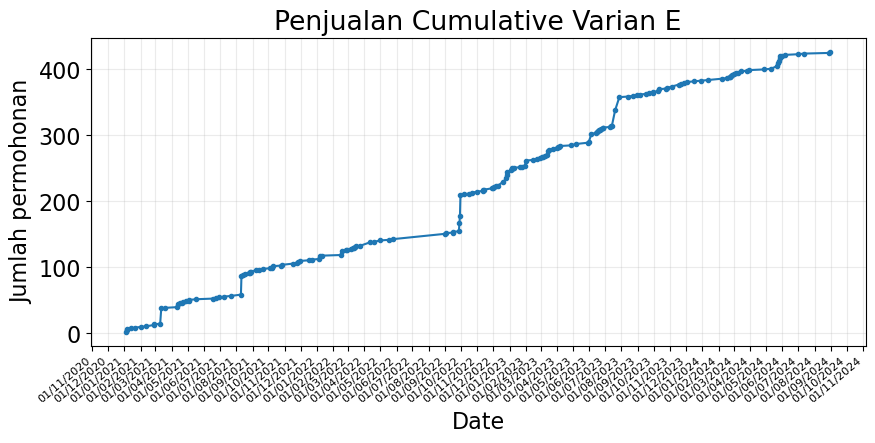

In [10]:
plot_time_series(df_E_count["Tgl. Mohon"], df_E_count["cumulative_sum"], 
                title="Penjualan Cumulative Varian E",
                xlabel="Date", ylabel="Jumlah permohonan")

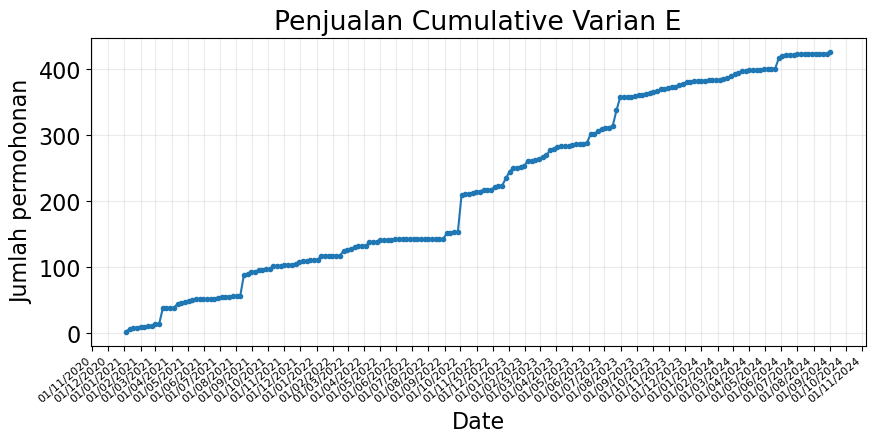

In [11]:
plot_time_series(df_E_weekly["Tgl. Mohon"], df_E_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian E",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [12]:
ADF_result = adfuller(df_E_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.5583566577354289
p-value: 0.8801168541331186


In [13]:
E_diff = np.diff(df_E_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(E_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -13.290646289092154
p-value: 7.374723524543927e-25


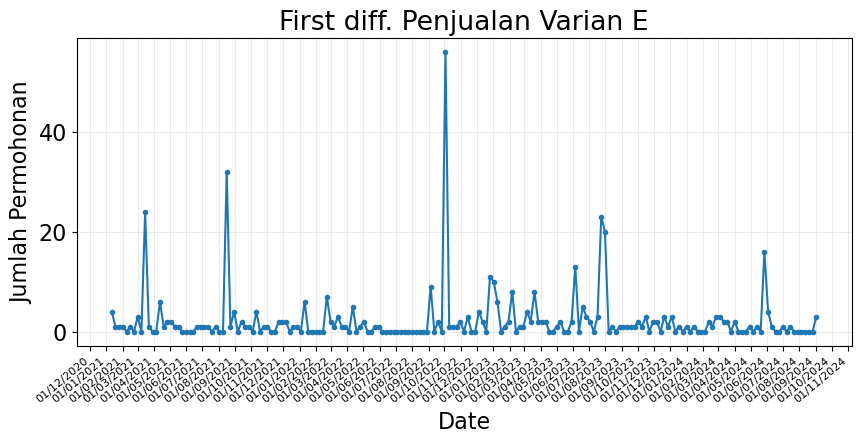

In [14]:
plot_time_series(df_E_weekly["Tgl. Mohon"].iloc[1:], E_diff, 
                 title="First diff. Penjualan Varian E",
                 xlabel="Date", ylabel="Jumlah Permohonan")

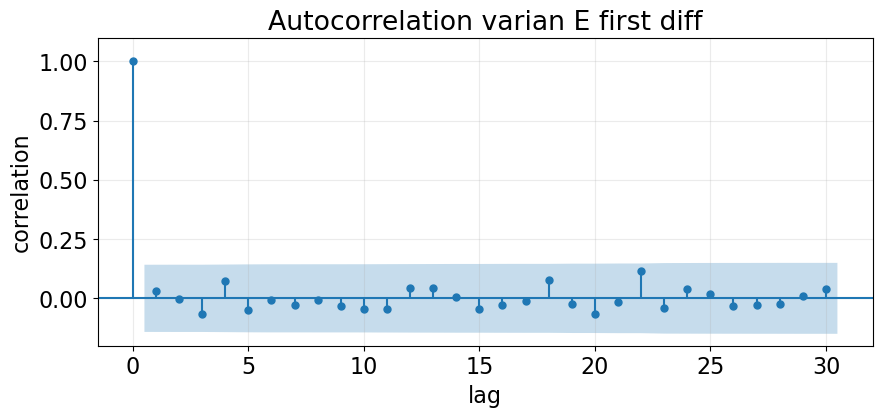

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(E_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian E first diff")
ax.grid("on")

plt.show(fig)

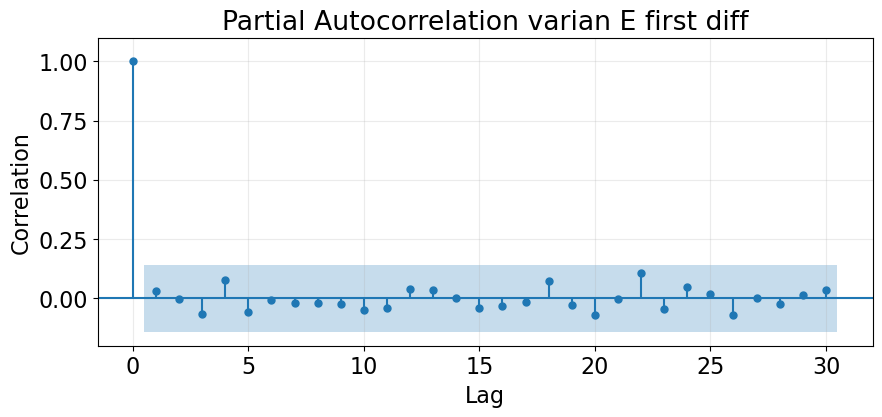

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(E_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian E first diff")
ax.grid("on")

plt.show()

#### harian

In [17]:
ADF_result = adfuller(df_E_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.6744342542596905
p-value: 0.8532609816368074


fisrt diff (_d_=1)

In [18]:
E_diff = np.diff(df_E_count["cumulative_sum"], n=1)
ADF_result = adfuller(E_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -10.754267054440884
p-value: 2.6174268094557774e-19


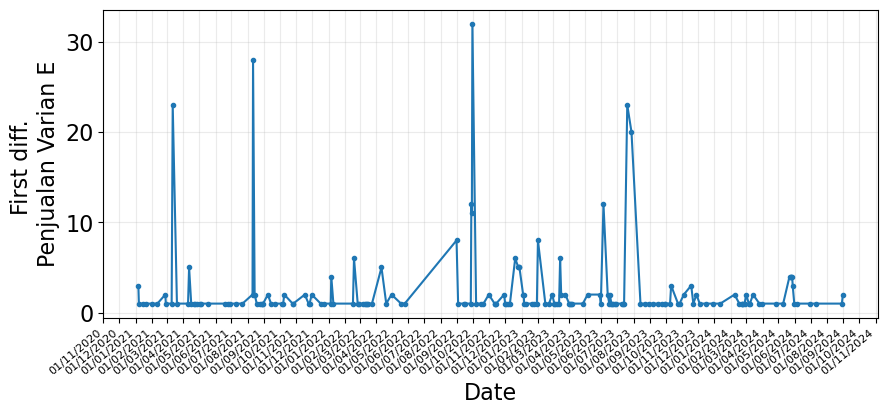

In [19]:
plot_time_series(df_E_count["Tgl. Mohon"].iloc[1:], E_diff, 
                #  title="First diff. Penjualan Varian E",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian E")

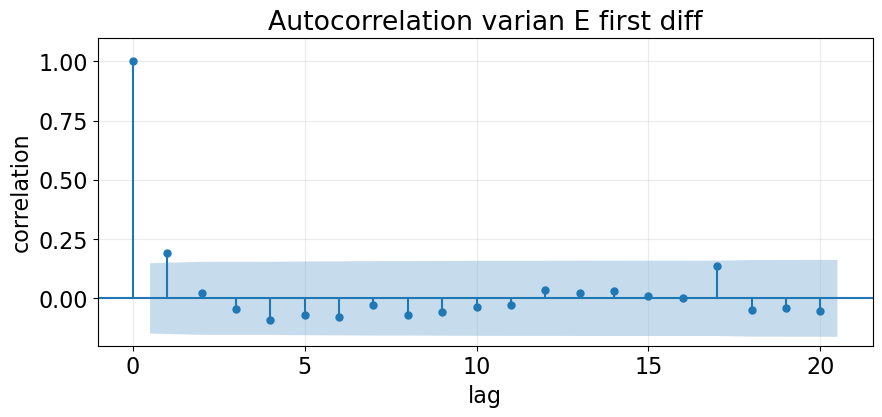

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(E_diff, lags=20, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian E first diff")
ax.grid("on")

plt.show(fig)

MA(1)

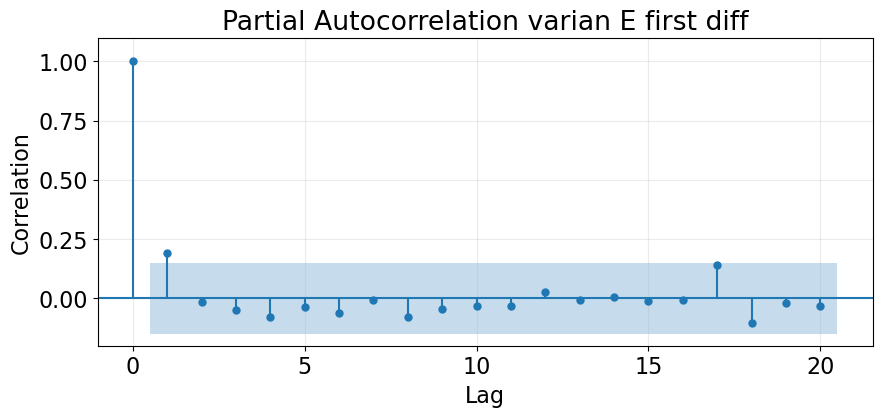

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(E_diff, lags=20, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian E first diff")
ax.grid("on")

plt.show()

AR(1)

### Data Splitting

In [22]:
df_E_diff = pd.DataFrame({
    "Tgl. Mohon": df_E_count["Tgl. Mohon"].iloc[1:],
    "E_diff": E_diff})

split_idx = int(0.8 * len(df_E_diff))
df_train = df_E_diff.iloc[:split_idx].copy()
df_test = df_E_diff.iloc[split_idx:].copy()


print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (139, 35)


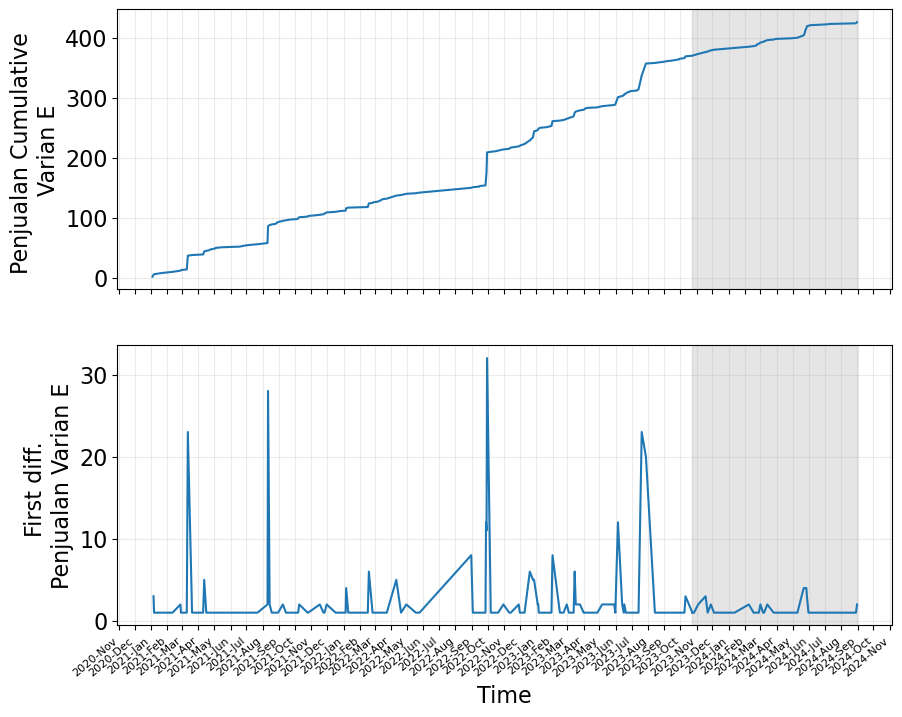

In [23]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_E_count["Tgl. Mohon"], df_E_count["cumulative_sum"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan Cumulative \nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian E")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### MA (1) AR(1)

In [24]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, 
                      method: str) -> list:
  """
  The following models using all the dataframe (train + test),
  because we roll out forecast with a correct data with the length
  of forecast is equal to `horizon`
  """
  total_len = train_len + horizon

  if method == "mean":
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i]["E_diff"])
      pred_mean.extend(mean for _ in range(window))
    # print(len(pred_mean), horizon)
    if len(pred_mean) > horizon:  # cut over counting in (mean for _ in range(window))
      pred_mean = pred_mean[:horizon]

    return pred_mean

  elif method == "last":
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i]["E_diff"].iloc[-1]
      pred_last_value.extend(last_value for _ in range(window))

    if len(pred_last_value) > horizon:  # cut over counting in (last_value for _ in range(window))
      pred_last_value = pred_last_value[:horizon]

    return pred_last_value

  elif method == "MA":
    pred_MA = []

    for i in range(train_len, total_len, window):
      # model = ARMA(df[:i]["E_diff"], order=(0, 1))
      model = SARIMAX(df[:i]["E_diff"], order=(0, 0, 1))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_MA.extend(oos_pred)

    if len(pred_MA) > horizon:  # cut over counting in (.iloc[-window:])
      pred_MA = pred_MA[:horizon]

    return pred_MA

  elif method == "AR":
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i]["E_diff"], order=(1, 0, 0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]   # oos: output of sarimax
      pred_AR.extend(oos_pred)

    return pred_AR

In [25]:
pred_df = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)
WINDOW = 7

pred_mean = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_MA = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "MA")
pred_AR = rolling_forecast(df_E_diff, TRAIN_LEN, HORIZON, WINDOW, "AR")

pred_df["pred_mean"] = pred_mean
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_MA"] = pred_MA
pred_df["pred_AR"] = pred_AR

pred_df

,Tgl. Mohon,E_diff,pred_mean,pred_last_value,pred_MA,pred_AR
140,2023-10-24,1,2.640288,3,0.820864,1.097133
141,2023-10-27,1,2.640288,3,0.000000,0.401233
142,2023-11-04,2,2.640288,3,0.000000,0.146735
143,2023-11-18,3,2.640288,3,0.000000,0.053663
144,2023-11-22,1,2.640288,3,0.000000,0.019625
145,2023-11-28,2,2.640288,3,0.000000,0.007177
146,2023-12-04,1,2.640288,3,0.000000,0.002625
147,2023-12-16,1,2.589041,1,0.127342,0.367783
148,2023-12-30,1,2.589041,1,0.000000,0.135265
149,2024-01-12,1,2.589041,1,0.000000,0.049748


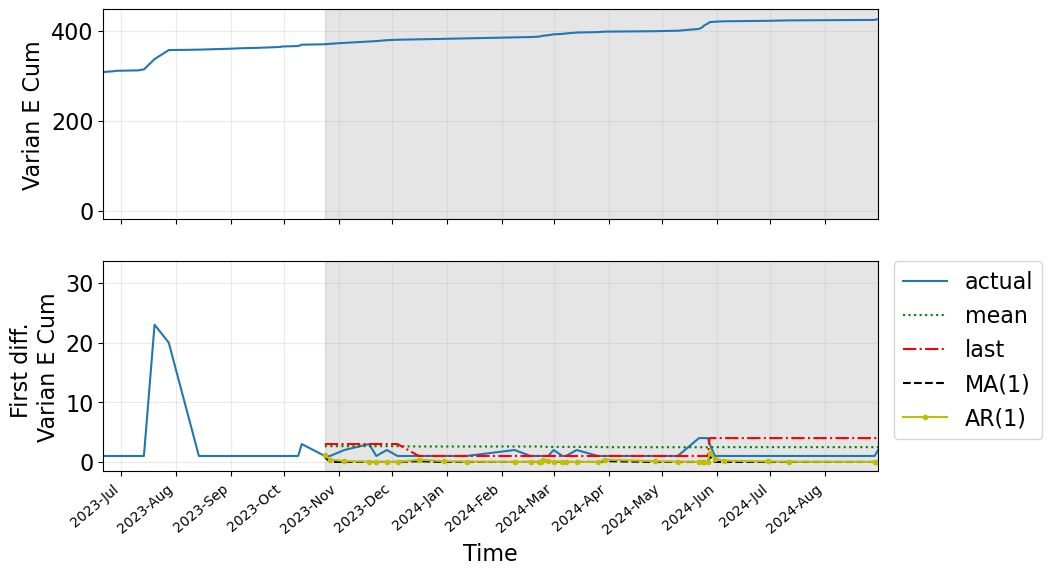

In [26]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))


# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size (10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

axes[0].grid("on")
axes[0].set_ylabel("Varian E Cum")
axes[0].set_xlim(xlim)


plt.show(fig)

In [27]:
mse_mean = mean_squared_error(pred_df["E_diff"], pred_df["pred_mean"])
mse_last = mean_squared_error(pred_df["E_diff"], pred_df["pred_last_value"])
mse_MA = mean_squared_error(pred_df["E_diff"], pred_df["pred_MA"])
mse_AR = mean_squared_error(pred_df["E_diff"], pred_df["pred_AR"])

print(f"MSE mean: {mse_mean}")
print(f"MSE last: {mse_last}")
print(f"MSE MA: {mse_MA}")
print(f"MSE AR: {mse_AR}")

MSE mean: 1.904017886678339
MSE last: 3.057142857142857
MSE MA: 3.4980278763941386
MSE AR: 3.2797808542229054


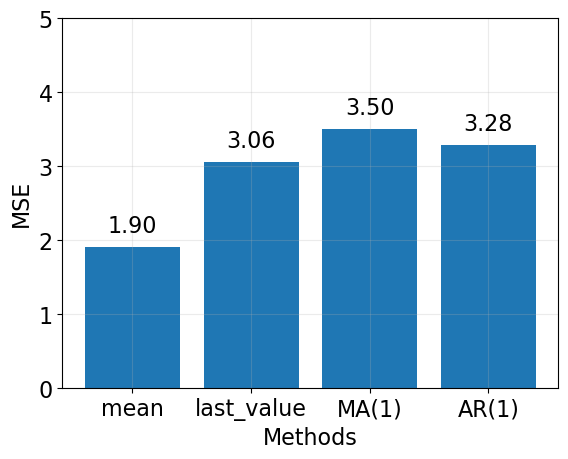

In [28]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean, mse_last, mse_MA, mse_AR]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 5])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [29]:
idx_y0 = len(df_train) + 1 
y0 = df_E_count.iloc[idx_y0]["cumulative_sum"]
# print(y0)
df_test_E = df_E_count[idx_y0:].copy()
df_test_E["pred_mean"] = y0 + pred_df["pred_mean"].cumsum()
df_test_E["pred_last_value"] = y0 + pred_df["pred_last_value"].cumsum()
df_test_E["pred_MA"] = y0 + pred_df["pred_MA"].cumsum()
df_test_E["pred_AR"] = y0 + pred_df["pred_AR"].cumsum()
df_test_E.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_last_value,pred_MA,pred_AR
140,2023-10-24,1,370,372.640288,373,370.820864,371.097133
141,2023-10-27,1,371,375.280576,376,370.820864,371.498366
142,2023-11-04,2,373,377.920863,379,370.820864,371.645101
143,2023-11-18,3,376,380.561151,382,370.820864,371.698764
144,2023-11-22,1,377,383.201439,385,370.820864,371.718389


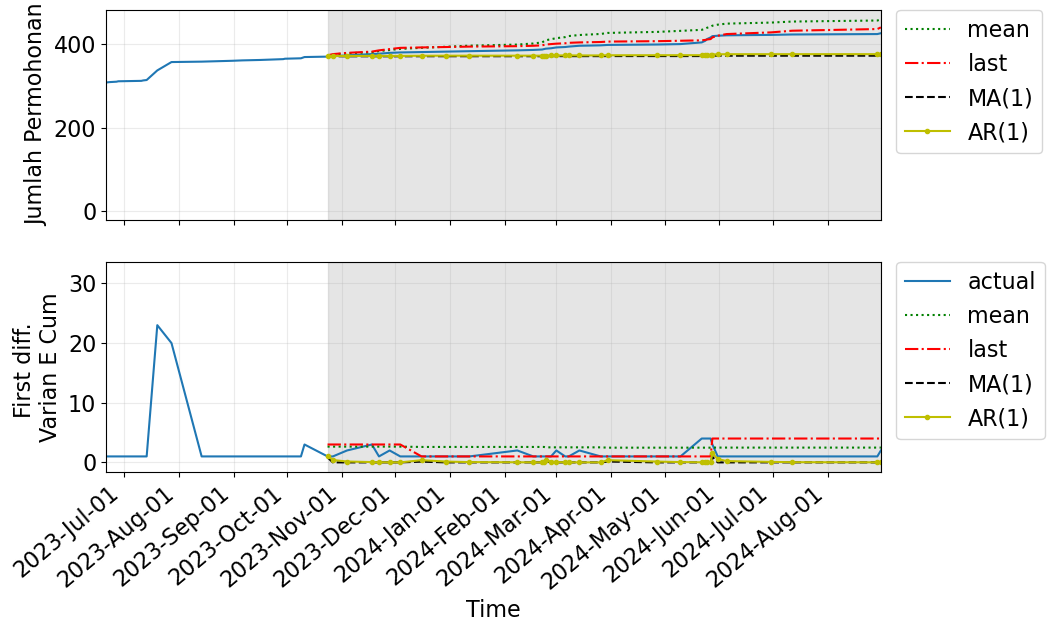

In [30]:
df_train_extended = pd.concat([df_train, df_test.iloc[:1]])

start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

# -- second row
axes[1].plot(df_train_extended["Tgl. Mohon"], df_train_extended["E_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["E_diff"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nVarian E Cum")
axes[1].grid("on")

# -- prediction
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_mean"], "g:", label="mean")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_last_value"], "r-.", label="last")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_MA"], "k--", label="MA(1)")
axes[1].plot(pred_df["Tgl. Mohon"], pred_df["pred_AR"], "y.-", label="AR(1)")


# add forecast area
for j in range(2):
  axes[j].axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
axes[1].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

# -- first row
axes[0].plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])

# -- prediction for the original data
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_mean"], "g:", label="mean")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_last_value"], "r-.", label="last")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_MA"], "k--", label="MA(1)")
axes[0].plot(df_test_E['Tgl. Mohon'], df_test_E["pred_AR"], "y.-", label="AR(1)")

axes[0].grid("on")
axes[0].set_ylabel("Jumlah Permohonan")
axes[0].set_xlim(xlim)
axes[0].set_ylim()
axes[0].legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)


plt.show(fig)

### Evaluasi MA(1) AR(1)

MAE

In [31]:
mae_mean_undiff = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"])
mae_last_undiff = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"])
mae_MA_undiff   = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"])
mae_AR_undiff   = mean_absolute_error(df_test_E["cumulative_sum"], df_test_E["pred_AR"])

print(f"MAE mean: {mae_mean_undiff}")
print(f"MAE last: {mae_last_undiff}")
print(f"MAE MA: {mae_MA_undiff}")
print(f"MAE AR: {mae_AR_undiff}")

MAE mean: 20.31131225160992
MAE last: 7.628571428571429
MAE MA: 24.77702192061395
MAE AR: 22.9520647355969


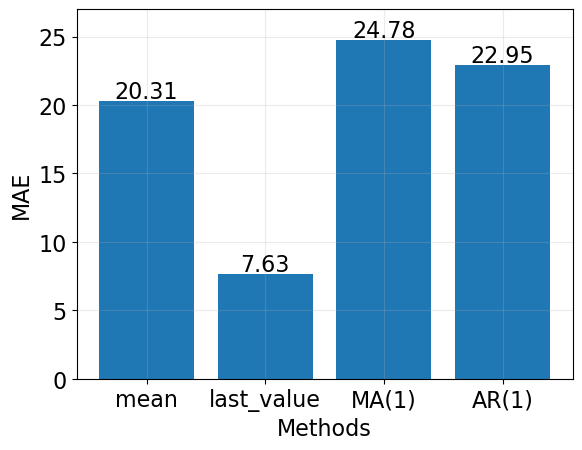

In [32]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff, mae_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 27])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [33]:
mse_mean_undiff = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"])
mse_last_undiff = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"])
mse_MA_undiff   = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"])
mse_AR_undiff   = mean_squared_error(df_test_E["cumulative_sum"], df_test_E["pred_AR"])

print(f"MSE mean: {mse_mean_undiff}")
print(f"MSE last: {mse_last_undiff}")
print(f"MSE MA: {mse_MA_undiff}")
print(f"MSE AR: {mse_AR_undiff}")

MSE mean: 502.8432959478666
MSE last: 69.11428571428571
MSE MA: 879.5874547888658
MSE AR: 762.0422855551167


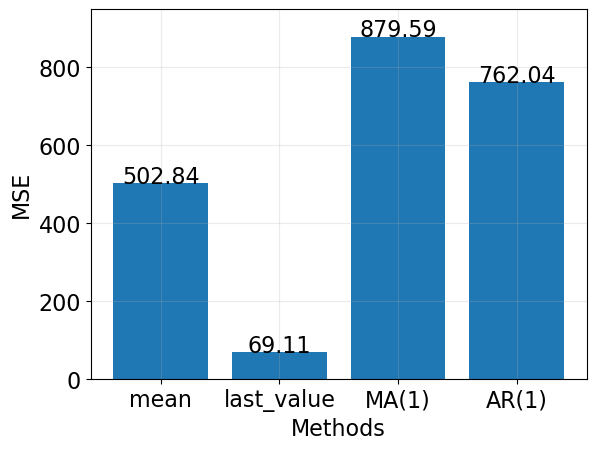

In [34]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mse_mean_undiff, mse_last_undiff, mse_MA_undiff, mse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 950])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [35]:
rmse_mean_undiff = np.sqrt(mse_mean_undiff)
rmse_last_undiff = np.sqrt(mse_last_undiff)
rmse_MA_undiff = np.sqrt(mse_MA_undiff)
rmse_AR_undiff = np.sqrt(mse_AR_undiff)

print(f"RMSE mean: {rmse_mean_undiff}")
print(f"RMSE last: {rmse_last_undiff}")
print(f"RMSE MA: {rmse_MA_undiff}")
print(f"RMSE AR: {rmse_AR_undiff}")

RMSE mean: 22.42416767569906
RMSE last: 8.31350020835302
RMSE MA: 29.657839685129897
RMSE AR: 27.605113395078032


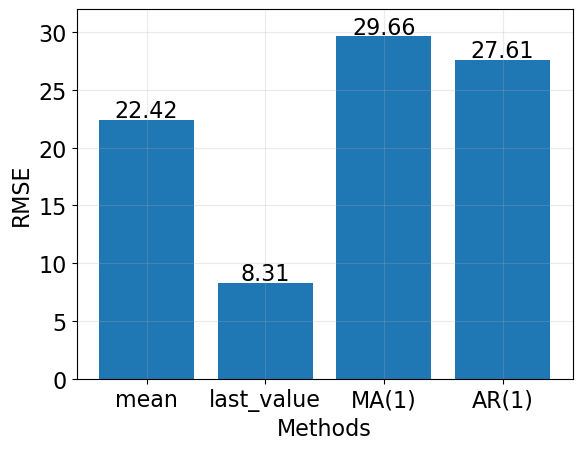

In [36]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [rmse_mean_undiff, rmse_last_undiff, rmse_MA_undiff, rmse_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 32])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [37]:
mape_mean_undiff = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_mean"]) * 100
mape_last_undiff = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_last_value"]) * 100
mape_MA_undiff   = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_MA"]) * 100
mape_AR_undiff   = mean_absolute_percentage_error(df_test_E["cumulative_sum"], df_test_E["pred_AR"]) * 100

print(f"MAPE mean: {mape_mean_undiff:.2f}%")
print(f"MAPE last: {mape_last_undiff:.2f}%")
print(f"MAPE MA: {mape_MA_undiff:.2f}%")
print(f"MAPE AR: {mape_AR_undiff:.2f}%")

MAPE mean: 5.05%
MAPE last: 1.94%
MAPE MA: 6.09%
MAPE AR: 5.64%


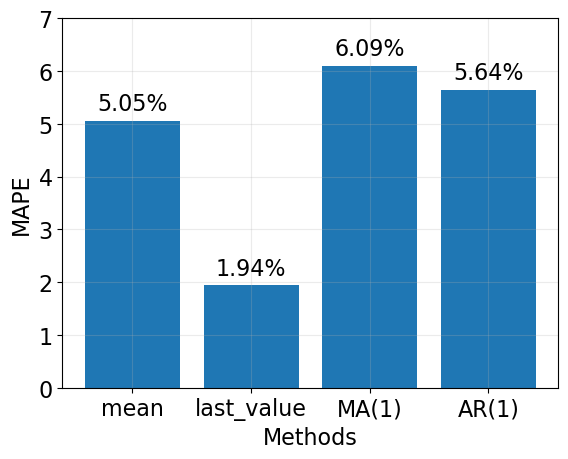

In [38]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mape_mean_undiff, mape_last_undiff, mape_MA_undiff, mape_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 7])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [39]:
naive = np.abs(np.diff(df_test_E["cumulative_sum"])).mean()

mase_mean_undiff = mae_mean_undiff / naive
mase_last_undiff = mae_last_undiff / naive
mase_MA_undiff   = mae_MA_undiff / naive
mase_AR_undiff   = mae_AR_undiff / naive

print(f"MASE mean: {mase_mean_undiff}")
print(f"MASE last: {mase_last_undiff}")
print(f"MASE MA: {mase_MA_undiff}")
print(f"MASE AR: {mase_AR_undiff}")

MASE mean: 12.331868152763166
MASE last: 4.631632653061225
MASE MA: 15.043191880372756
MASE AR: 13.935182160898117


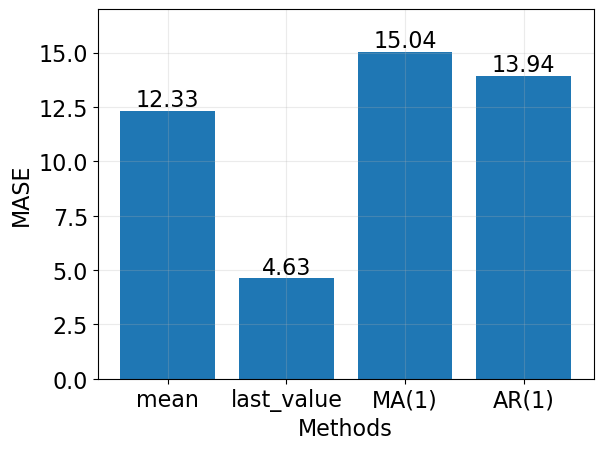

In [40]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "MA(1)", "AR(1)"]
y_array = [mase_mean_undiff, mase_last_undiff, mase_MA_undiff, mase_AR_undiff]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 17])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

### Data Splitting ARIMA

In [41]:
split_idx = int(0.8 * len(df_E_count))
df_train_arima = df_E_count.iloc[:split_idx].copy()
df_test_arima = df_E_count.iloc[split_idx:].copy()

print(f"(len(df_train_arima), len(df_test_arima)): {len(df_train_arima), len(df_test_arima)}")


(len(df_train_arima), len(df_test_arima)): (140, 35)


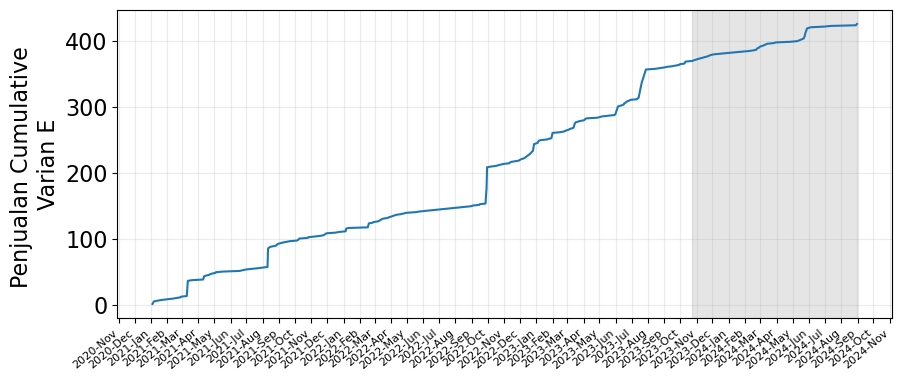

In [42]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_E_count['Tgl. Mohon'], df_E_count["cumulative_sum"])
ax.grid("on")
ax.set_ylabel("Penjualan Cumulative \nVarian E")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(8)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (2,1,1)

In [43]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [44]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 1

order_list = list(itertls.product(p_space, q_space))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [45]:
result_df = optimize_ARIMA(df_train_arima["cumulative_sum"], order_list, d,
                            enforce_invertibility=True,
                            enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(1, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 0)
(2, 1)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 0)
(3, 1)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 3)


c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(2, 1)",841.374836
1,"(1, 2)",841.456670
2,"(1, 3)",843.314997
3,"(3, 1)",843.339106
4,"(2, 2)",843.352018
5,"(1, 1)",844.406005
6,"(3, 2)",845.360265
7,"(2, 3)",845.405565
8,"(3, 3)",850.216805
9,"(1, 0)",853.678563


In [46]:
best_p, best_q = (2, 1)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (2, 1)


In [47]:
model_arima_best = SARIMAX(df_train_arima["cumulative_sum"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


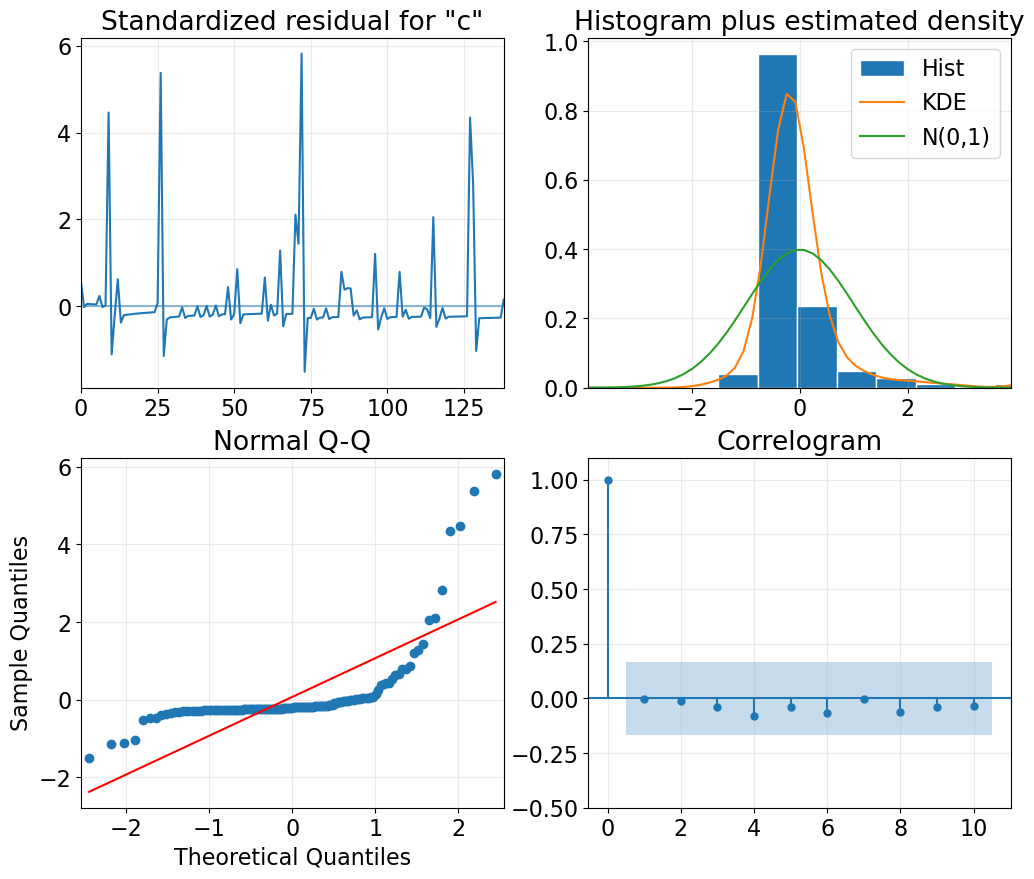

In [48]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [49]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.001259,0.971696
2,0.023537,0.988300
3,0.231176,0.972406
4,1.161335,0.884423
5,1.412342,0.922958
6,2.045232,0.915492
7,2.045916,0.957255
8,2.661127,0.953794
9,2.878476,0.968919
10,2.986311,0.981744


_p-value_ > 0.05 untuk semua lag, maka tidak ada autokorelasi dalam residual. Artiinya model menangkap semua pola dalam data

In [50]:
df_test_pred_arima = df_test_arima.copy()

TRAIN_LEN = len(df_train_arima)
HORIZON = len(df_test_arima)

pred_mean = np.ones(HORIZON)*np.mean(df_train_arima["cumulative_sum"])
pred_naive_seasonal = df_train_arima["cumulative_sum"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred_arima["pred_mean"] = pred_mean
df_test_pred_arima["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred_arima["pred_arima"] = pred_arima

df_test_pred_arima.head()

,Tgl. Mohon,count,cumulative_sum,pred_mean,pred_naive_seasonal,pred_arima
140,2023-10-24,1,370,179.571429,275,371.632582
141,2023-10-27,1,371,179.571429,277,374.195586
142,2023-11-04,2,373,179.571429,279,376.745411
143,2023-11-18,3,376,179.571429,280,379.292740
144,2023-11-22,1,377,179.571429,281,381.839593


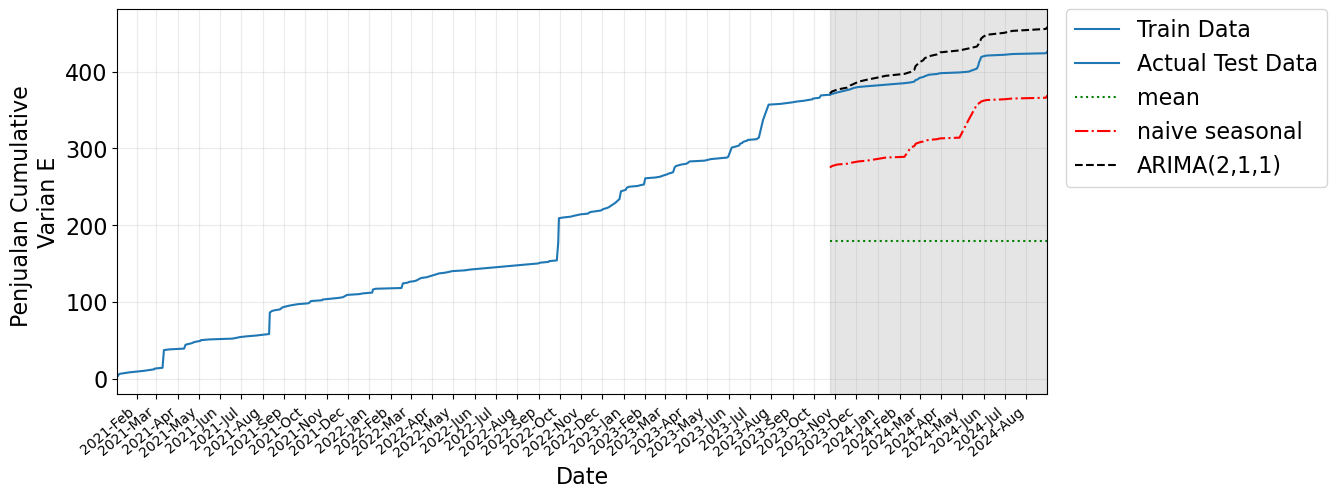

In [51]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 0  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["cumulative_sum"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["cumulative_sum"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian E")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

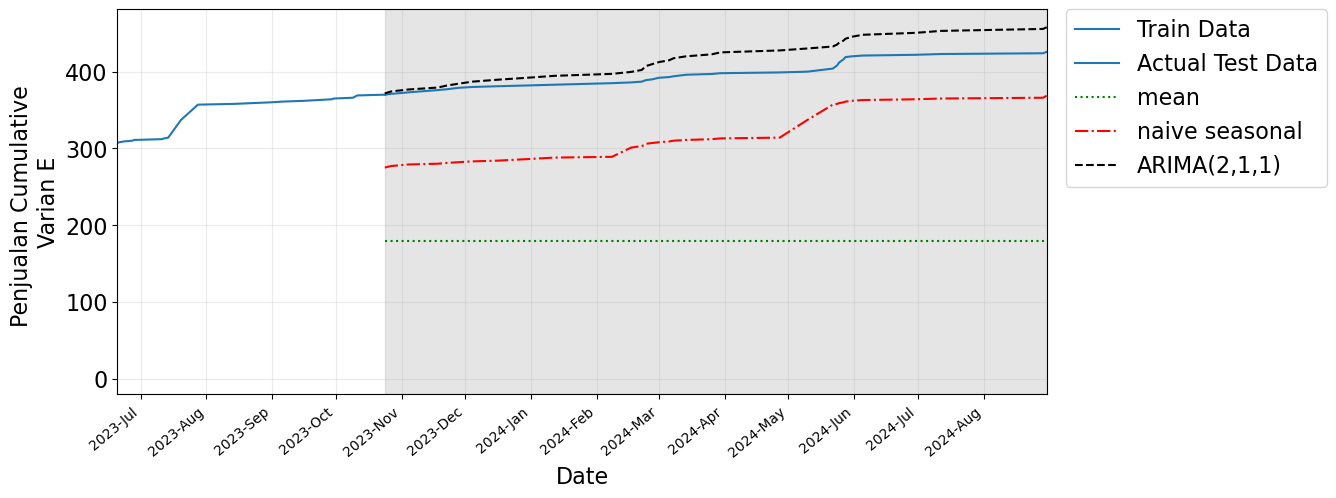

In [52]:
df_train_arima_extended = pd.concat([df_train_arima, df_test_arima.iloc[:1]], ignore_index=True)

start_idx = 120  # for better visualization
xlim = [df_train_arima_extended["Tgl. Mohon"].iloc[start_idx], df_test_arima["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_train_arima_extended["Tgl. Mohon"], df_train_arima_extended["cumulative_sum"], label="Train Data")
ax.plot(df_test_arima["Tgl. Mohon"], df_test_arima["cumulative_sum"], color="tab:blue", label="Actual Test Data")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan Cumulative \nVarian E")

# -- prediction
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred_arima["Tgl. Mohon"], df_test_pred_arima["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test_arima['Tgl. Mohon'].iloc[0], df_test_arima['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(10)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi ARIMA (2,1,1)

MAE

In [53]:
mae_mean           = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_arima"])

print(f"MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"MAE ARIMA: {mae_arima}")

MAE mean: 216.45714285714286
MAE naive seasonal: 78.22857142857143
MAE ARIMA: 18.917673630556404


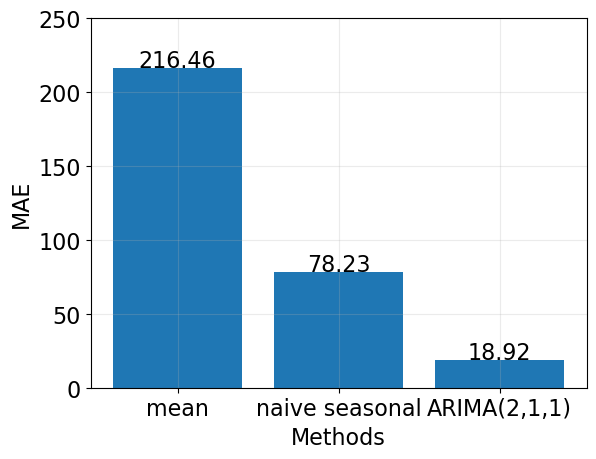

In [54]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MSE

In [55]:
mse_mean           = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_mean"])
mse_naive_seasonal = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_naive_seasonal"])
mse_arima          = mean_squared_error(df_test_pred_arima["cumulative_sum"], df_test_pred_arima["pred_arima"])

print(f"MSE mean: {mse_mean}")
print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE ARIMA: {mse_arima}")

MSE mean: 47137.09387755102
MSE naive seasonal: 6401.4857142857145
MSE ARIMA: 449.7718959466146


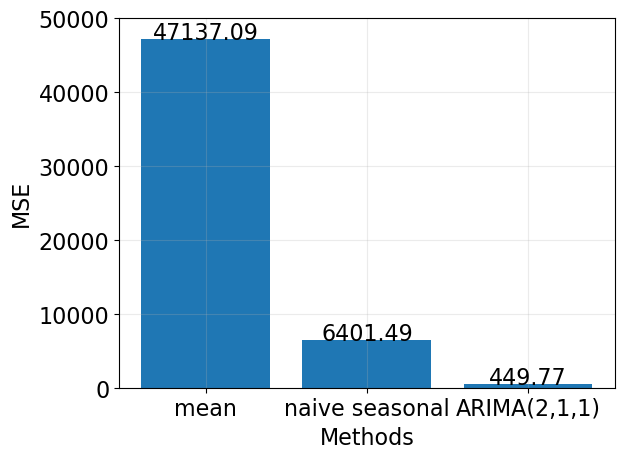

In [56]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mse_mean, mse_naive_seasonal, mse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 50000])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

RMSE

In [57]:
rmse_mean           = np.sqrt(mse_mean)
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)

print(f"RMSE mean: {rmse_mean}")
print(f"RMSE naive seasonal: {rmse_naive_seasonal}")
print(f"RMSE ARIMA: {rmse_arima}")

RMSE mean: 217.1107871054569
RMSE naive seasonal: 80.0092851754452
RMSE ARIMA: 21.20782628999527


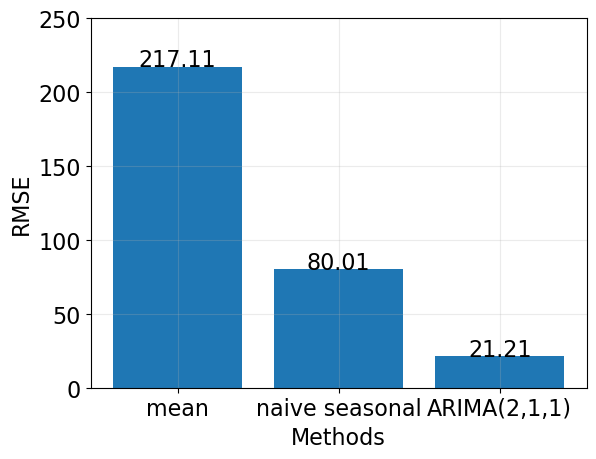

In [58]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [rmse_mean, rmse_naive_seasonal, rmse_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 250])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)

MAPE

In [59]:
mape_mean           = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_mean"]) / df_test_pred_arima["cumulative_sum"])) * 100
mape_naive_seasonal = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_naive_seasonal"]) / df_test_pred_arima["cumulative_sum"])) * 100
mape_arima          = np.mean(np.abs((df_test_pred_arima["cumulative_sum"] - df_test_pred_arima["pred_arima"]) / df_test_pred_arima["cumulative_sum"])) * 100

print(f"MAPE mean: {mape_mean:.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

MAPE mean: 54.58%
MAPE naive seasonal: 19.95%
MAPE ARIMA: 4.69%


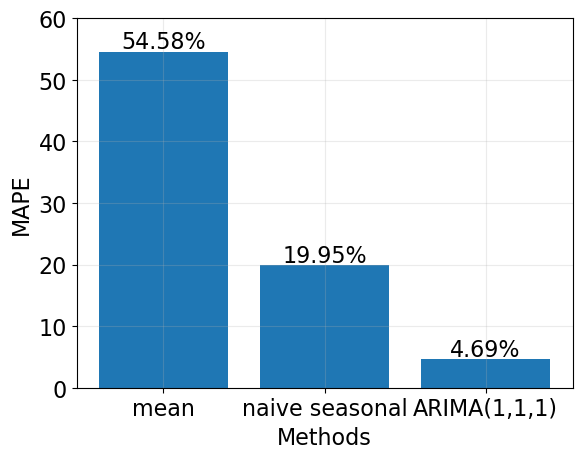

In [60]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(1,1,1)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 60])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [61]:
naive = np.abs(np.diff(df_test_pred_arima["cumulative_sum"])).mean()

mase_mean           = mae_mean_undiff / naive
mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima          = mae_arima / naive

print(f"MASE mean: {mase_mean}")
print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE ARIMA: {mase_arima}")

MASE mean: 12.331868152763166
MASE naive seasonal: 47.49591836734694
MASE ARIMA: 11.485730418552103


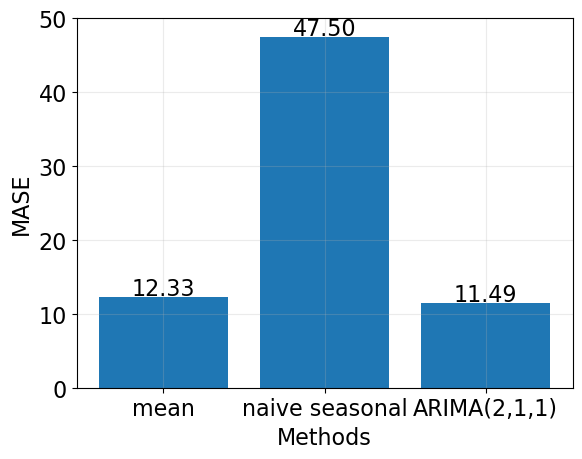

In [62]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(2,1,1)"]
y_array = [mase_mean, mase_naive_seasonal, mase_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 50])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)